# Benchmark Modelling

In [376]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [377]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

%matplotlib inline

In [378]:
matplotlib.style.use('seaborn-v0_8')  

In [379]:
device_name = 'TESLA'

In [380]:
tesla_root_dir = '/Users/diego/Desktop/BENCHMARK_TESLA_67M_WITH_BYTES'
hydra_root_dir = '/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES'
nebula_root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [381]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'teal'

CPU_COLOR='maroon'


In [382]:
plot_save_dir = './plots/'

## Utils 

In [383]:
def get_path(*entries):
    return os.path.join(*entries)

In [384]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [385]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [386]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [387]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [388]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [389]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [390]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str,root_dir_to_use=tesla_root_dir) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir_to_use + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [391]:
def get_min_cpu(bench_name:str,locations: List[str] = [nebula_root_dir,hydra_root_dir]) -> pd.DataFrame:
    instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    final_machine_mins = pd.DataFrame()

    for root_dir in locations:

        machine_mins = pd.DataFrame()

        for compiler_location, display_name in instances:
            df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv')
            
            df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
            df = df.rename(columns={'real_time':display_name})
            
            if machine_mins.empty:
                machine_mins = df
            else: 
                machine_mins = pd.merge(machine_mins,df,on='n')

        machine_mins['time'] = machine_mins[[x for _,x in instances]].min(axis=1)
        machine_mins = machine_mins.drop(columns=[x for _,x in instances])

        if final_machine_mins.empty:
            final_machine_mins = machine_mins
        else:
            final_machine_mins = pd.merge(final_machine_mins,machine_mins,on='n')

    final_machine_mins['CPU'] = final_machine_mins[['time_x','time_y']].min(axis=1)
    final_machine_mins = final_machine_mins.drop(columns=['time_x','time_y'])

    return final_machine_mins

In [392]:
def get_raw_times_and_speed(benchmark_name:str) -> Tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    min_cpu_time = get_min_cpu(benchmark_name)
    min_gpu_tesla_time = par_data_algo('TESLA_GPU','TESLA',bench_name=benchmark_name)

    merged_time_values = pd.merge(min_gpu_tesla_time,min_cpu_time,on='n')

    merged_time_values = merged_time_values.rename(columns={'TESLA':'Nvidia Tesla T4 GPU 16GB'})
    merged_time_values = merged_time_values.rename(columns={'CPU':'Best achieved CPU runtime'})


    # calc speedup
    speedup_values = pd.merge(min_gpu_tesla_time,min_cpu_time,on='n')
    speedup_values['speedup'] = speedup_values['CPU'] / speedup_values['TESLA']
    speedup_values = speedup_values.drop(columns=['CPU','TESLA'])
    speedup_values = speedup_values.rename(columns={'speedup':'Speedup'})


    return min_cpu_time,min_gpu_tesla_time,merged_time_values,speedup_values


# `b1_1_for_each_linear_mandelbrot`

In [393]:
benchmark_name = "b1_1_for_each_linear_mandelbrot"

min_cpu_time,min_gpu_tesla_time,merged_time_values,speedup_values = get_raw_times_and_speed(benchmark_name=benchmark_name)

In [394]:
min_gpu_tesla_time

,TESLA,n
0,6856.33,32
1,8577.32,64
2,8570.15,128
3,8574.30,256
4,8567.54,512
5,8566.58,1024
6,8580.10,2048
7,8589.15,4096
8,8637.03,8192
9,8700.60,16384


In [395]:
merged_time_values

,Nvidia Tesla T4 GPU 16GB,n,Best achieved CPU runtime
0,6856.33,32,4538.04
1,8577.32,64,5341.90
2,8570.15,128,5385.12
3,8574.30,256,5785.94
4,8567.54,512,5741.60
5,8566.58,1024,6808.78
6,8580.10,2048,7039.08
7,8589.15,4096,10132.20
8,8637.03,8192,14731.10
9,8700.60,16384,24928.00


In [396]:
speedup_values

,n,Speedup
0,32,0.661876
1,64,0.622794
2,128,0.628358
3,256,0.674800
4,512,0.670157
5,1024,0.794807
6,2048,0.820396
7,4096,1.179651
8,8192,1.705575
9,16384,2.865090


### Plotting

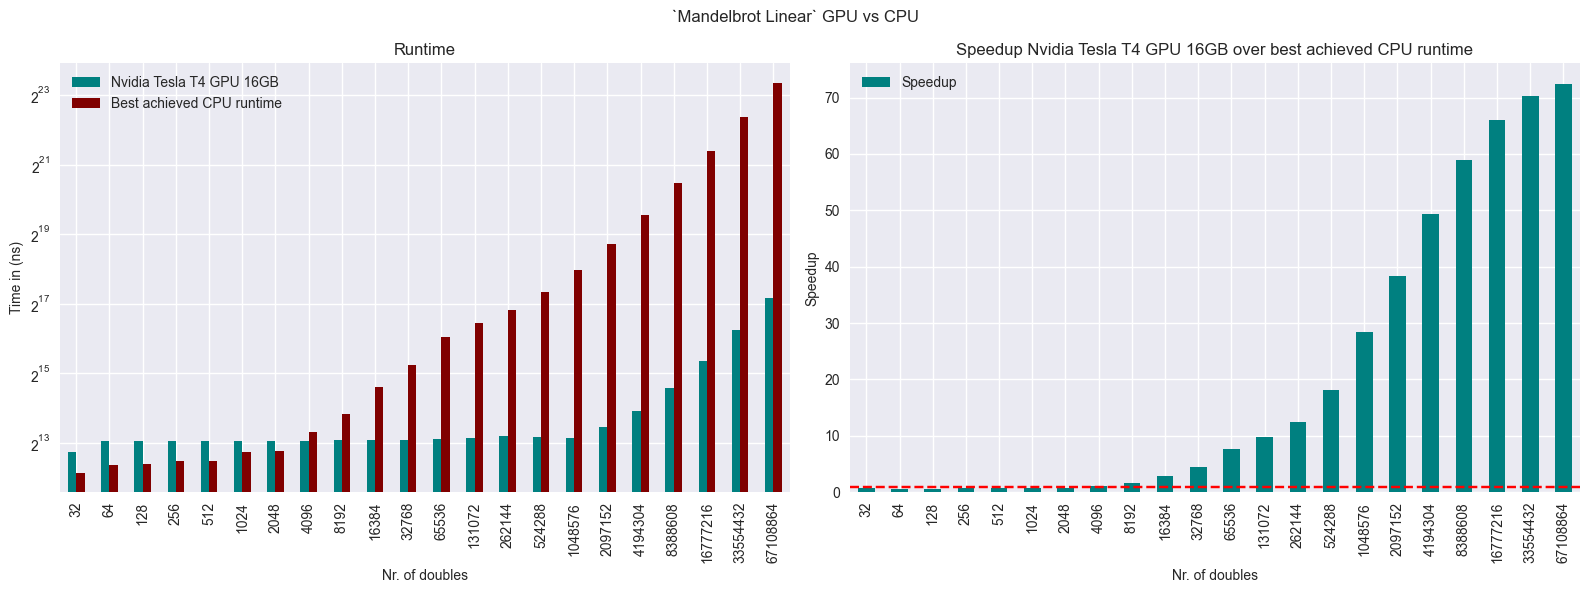

In [397]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))


# plot runtime
ax_1 = merged_time_values.plot(kind='bar',x='n',align='center',color=[NVC_GPU_COLOR,CPU_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of doubles')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# speeduo
ax_2 = speedup_values.plot(kind='bar',
                                                                       x='n',
                                                                       align='center',
                                                                       color=[NVC_GPU_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Nr. of doubles')
ax_2.set_title('Speedup Nvidia Tesla T4 GPU 16GB over best achieved CPU runtime')



fig.suptitle(f"`Mandelbrot Linear` GPU vs CPU")

fig.tight_layout()

plot(f"`{benchmark_name}` GPU vs CPU")

# `b4_1_merge`

In [398]:
benchmark_name = "b4_1_merge_cutoff_wrapper"

min_cpu_time,min_gpu_tesla_time,merged_time_values,speedup_values = get_raw_times_and_speed(benchmark_name=benchmark_name)

In [399]:
min_cpu_time

,n,CPU
0,4,4.228690e+01
1,8,5.285980e+01
2,16,6.970600e+01
3,32,1.079950e+02
4,64,1.583790e+02
5,128,2.659220e+02
6,256,4.820310e+02
7,512,9.136000e+02
8,1024,5.407940e+03
9,2048,8.906340e+03


In [400]:
min_gpu_tesla_time

,TESLA,n
0,15515.6,4
1,15554.0,8
2,15894.1,16
3,16665.1,32
4,16460.7,64
5,15796.0,128
6,16747.0,256
7,15600.5,512
8,15695.8,1024
9,15957.8,2048


In [401]:
merged_time_values

,Nvidia Tesla T4 GPU 16GB,n,Best achieved CPU runtime
0,15515.6,4,4.228690e+01
1,15554.0,8,5.285980e+01
2,15894.1,16,6.970600e+01
3,16665.1,32,1.079950e+02
4,16460.7,64,1.583790e+02
5,15796.0,128,2.659220e+02
6,16747.0,256,4.820310e+02
7,15600.5,512,9.136000e+02
8,15695.8,1024,5.407940e+03
9,15957.8,2048,8.906340e+03


In [402]:
speedup_values

,n,Speedup
0,4,0.002725
1,8,0.003398
2,16,0.004386
3,32,0.006480
4,64,0.009622
5,128,0.016835
6,256,0.028783
7,512,0.058562
8,1024,0.344547
9,2048,0.558118


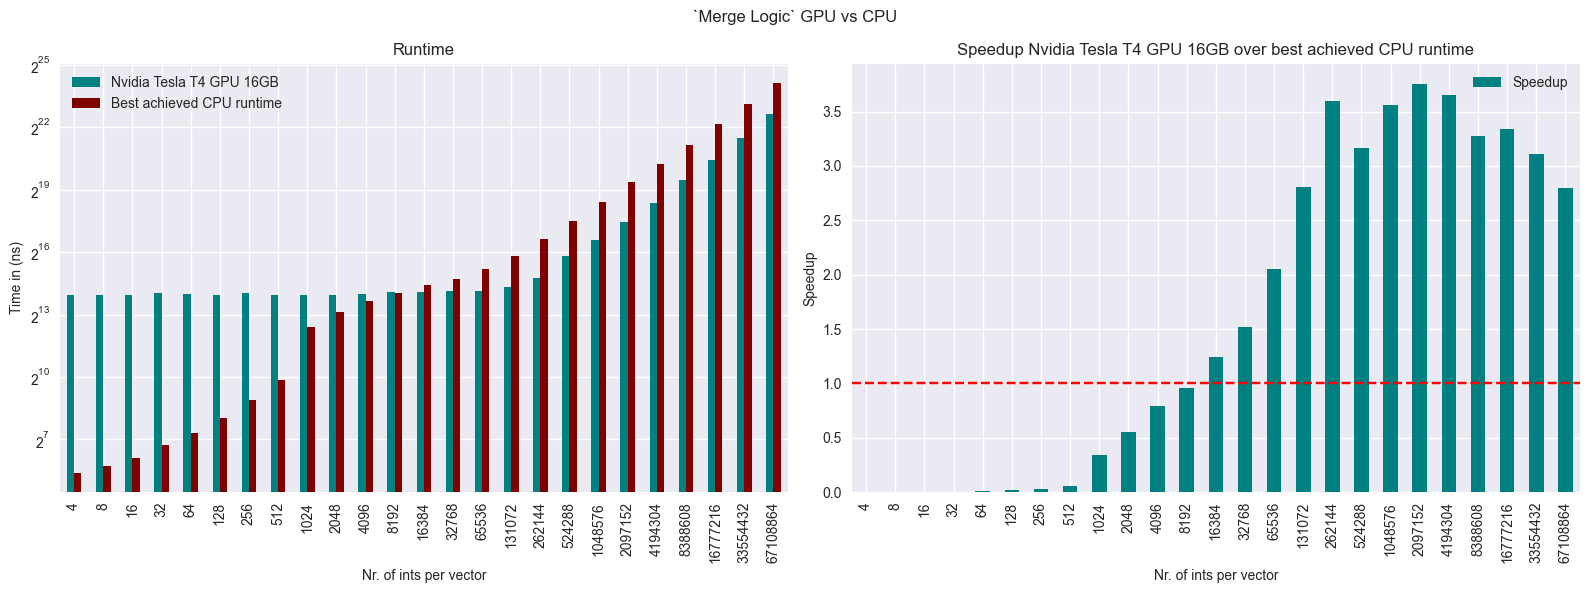

In [403]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))


# plot runtime
ax_1 = merged_time_values.plot(kind='bar',x='n',align='center',color=[NVC_GPU_COLOR,CPU_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints per vector')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# speeduo
ax_2 = speedup_values.plot(kind='bar',
                                                                       x='n',
                                                                       align='center',
                                                                       color=[NVC_GPU_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Nr. of ints per vector')
ax_2.set_title('Speedup Nvidia Tesla T4 GPU 16GB over best achieved CPU runtime')



fig.suptitle(f"`Merge Logic` GPU vs CPU")

fig.tight_layout()

plot(f"`b4_1_merge` GPU vs CPU")

## `b6_1_inclusive_scan`

In [404]:
benchmark_name = "b6_1_inclusive_scan"

min_cpu_time,min_gpu_tesla_time,merged_time_values,speedup_values = get_raw_times_and_speed(benchmark_name=benchmark_name)

In [405]:
min_cpu_time

,n,CPU
0,4,3.292030e+01
1,8,3.466260e+01
2,16,3.865960e+01
3,32,4.652310e+01
4,64,6.430150e+01
5,128,1.065600e+02
6,256,1.828230e+02
7,512,3.339910e+02
8,1024,6.476270e+02
9,2048,1.243400e+03


In [406]:
min_gpu_tesla_time

,TESLA,n
0,14309.3,4
1,14352.1,8
2,14973.8,16
3,15014.9,32
4,15705.8,64
5,14622.9,128
6,13568.2,256
7,13295.0,512
8,14840.3,1024
9,13675.7,2048


In [407]:
merged_time_values

,Nvidia Tesla T4 GPU 16GB,n,Best achieved CPU runtime
0,14309.3,4,3.292030e+01
1,14352.1,8,3.466260e+01
2,14973.8,16,3.865960e+01
3,15014.9,32,4.652310e+01
4,15705.8,64,6.430150e+01
5,14622.9,128,1.065600e+02
6,13568.2,256,1.828230e+02
7,13295.0,512,3.339910e+02
8,14840.3,1024,6.476270e+02
9,13675.7,2048,1.243400e+03


In [408]:
speedup_values

,n,Speedup
0,4,0.002301
1,8,0.002415
2,16,0.002582
3,32,0.003098
4,64,0.004094
5,128,0.007287
6,256,0.013474
7,512,0.025122
8,1024,0.043640
9,2048,0.090920


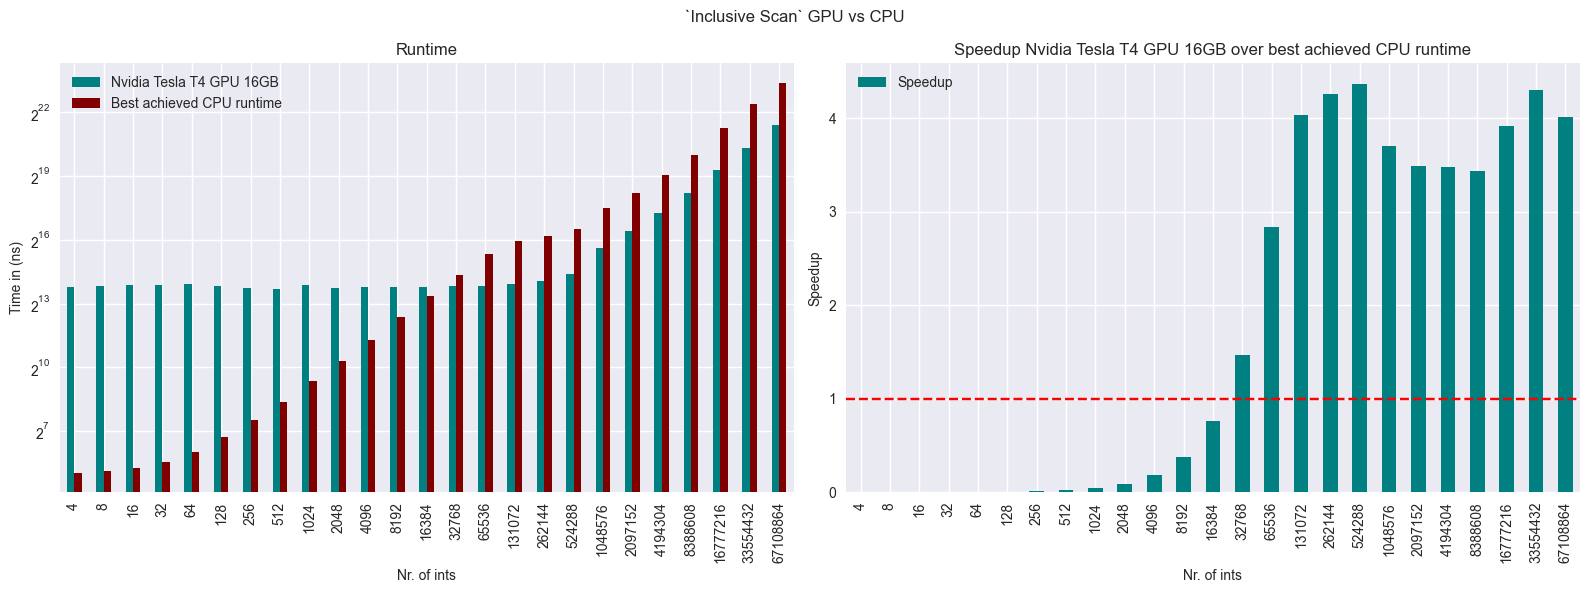

In [409]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))


# plot runtime
ax_1 = merged_time_values.plot(kind='bar',x='n',align='center',color=[NVC_GPU_COLOR,CPU_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# speeduo
ax_2 = speedup_values.plot(kind='bar',
                                                                       x='n',
                                                                       align='center',
                                                                       color=[NVC_GPU_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Speedup Nvidia Tesla T4 GPU 16GB over best achieved CPU runtime')



fig.suptitle(f"`Inclusive Scan` GPU vs CPU")

fig.tight_layout()

plot(f"`{benchmark_name}` GPU vs CPU")

## `b7_1_copy`

In [410]:
benchmark_name = "b7_1_copy"

min_cpu_time,min_gpu_tesla_time,merged_time_values,speedup_values = get_raw_times_and_speed(benchmark_name=benchmark_name)

In [411]:
min_cpu_time

,n,CPU
0,4,2283.77
1,8,4705.80
2,16,6015.48
3,32,6203.26
4,64,6095.40
5,128,5682.31
6,256,5611.51
7,512,5528.96
8,1024,5627.38
9,2048,6165.64


In [412]:
min_gpu_tesla_time

,TESLA,n
0,9.328170e+03,4
1,9.410170e+03,8
2,9.462140e+03,16
3,9.329800e+03,32
4,9.471740e+03,64
5,9.441920e+03,128
6,9.683580e+03,256
7,1.056240e+04,512
8,1.130290e+04,1024
9,1.157120e+04,2048


In [413]:
merged_time_values

,Nvidia Tesla T4 GPU 16GB,n,Best achieved CPU runtime
0,9.328170e+03,4,2283.77
1,9.410170e+03,8,4705.80
2,9.462140e+03,16,6015.48
3,9.329800e+03,32,6203.26
4,9.471740e+03,64,6095.40
5,9.441920e+03,128,5682.31
6,9.683580e+03,256,5611.51
7,1.056240e+04,512,5528.96
8,1.130290e+04,1024,5627.38
9,1.157120e+04,2048,6165.64


In [414]:
speedup_values

,n,Speedup
0,4,0.244825
1,8,0.500076
2,16,0.635742
3,32,0.664887
4,64,0.643535
5,128,0.601817
6,256,0.579487
7,512,0.523457
8,1024,0.497870
9,2048,0.532844


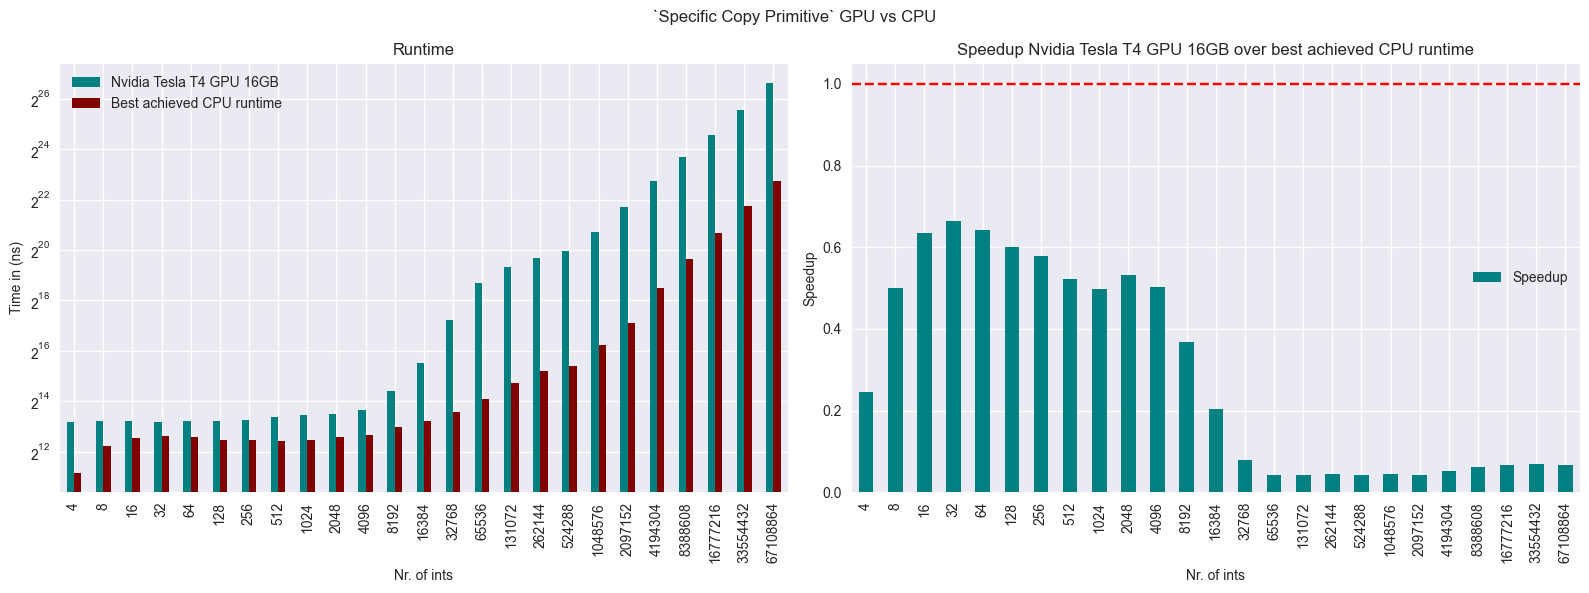

In [415]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))


# plot runtime
ax_1 = merged_time_values.plot(kind='bar',x='n',align='center',color=[NVC_GPU_COLOR,CPU_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# speeduo
ax_2 = speedup_values.plot(kind='bar',
                                                                       x='n',
                                                                       align='center',
                                                                       color=[NVC_GPU_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Speedup Nvidia Tesla T4 GPU 16GB over best achieved CPU runtime')



fig.suptitle(f"`Specific Copy Primitive` GPU vs CPU")

fig.tight_layout()

plot(f"`{benchmark_name}` GPU vs CPU")

## `b7_4_stencil_transform_number_to_neightbours_stdev`

In [416]:
benchmark_name = "b7_4_stencil_transform_number_to_neightbours_stdev"

min_cpu_time,min_gpu_tesla_time,merged_time_values,speedup_values = get_raw_times_and_speed(benchmark_name=benchmark_name)

In [417]:
min_cpu_time

,n,CPU
0,4,1253.56
1,8,3769.14
2,16,5662.59
3,32,6106.19
4,64,5784.17
5,128,5672.86
6,256,5807.14
7,512,5667.24
8,1024,5633.39
9,2048,5773.30


In [418]:
min_gpu_tesla_time

,TESLA,n
0,9971.11,4
1,9914.56,8
2,9965.24,16
3,9953.88,32
4,10088.30,64
5,10009.10,128
6,10010.50,256
7,9924.32,512
8,9948.52,1024
9,9934.96,2048


In [419]:
merged_time_values

,Nvidia Tesla T4 GPU 16GB,n,Best achieved CPU runtime
0,9971.11,4,1253.56
1,9914.56,8,3769.14
2,9965.24,16,5662.59
3,9953.88,32,6106.19
4,10088.30,64,5784.17
5,10009.10,128,5672.86
6,10010.50,256,5807.14
7,9924.32,512,5667.24
8,9948.52,1024,5633.39
9,9934.96,2048,5773.30


In [420]:
speedup_values

,n,Speedup
0,4,0.125719
1,8,0.380162
2,16,0.568234
3,32,0.613448
4,64,0.573354
5,128,0.566770
6,256,0.580105
7,512,0.571046
8,1024,0.566254
9,2048,0.581110


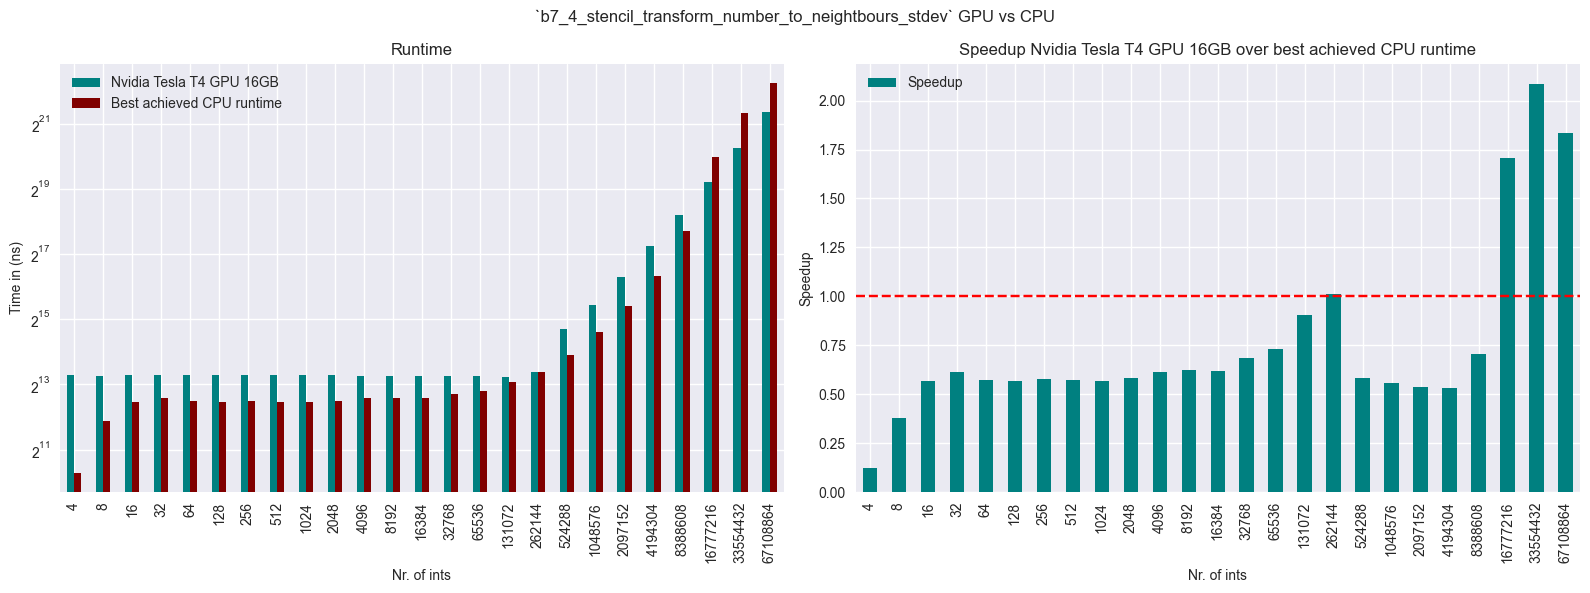

In [421]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))


# plot runtime
ax_1 = merged_time_values.plot(kind='bar',x='n',align='center',color=[NVC_GPU_COLOR,CPU_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# speeduo
ax_2 = speedup_values.plot(kind='bar',
                                                                       x='n',
                                                                       align='center',
                                                                       color=[NVC_GPU_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Speedup Nvidia Tesla T4 GPU 16GB over best achieved CPU runtime')



fig.suptitle(f"`{benchmark_name}` GPU vs CPU")

fig.tight_layout()

plot(f"`{benchmark_name}` GPU vs CPU")